# Analysis of Review Time vs Retention and Rating

This notebook explores how real review durations (ms) correlate with FSRS-estimated retrievability and the ratings provided by the user.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Add src to path
sys.path.append(os.path.abspath("../src"))

from simulate_fsrs import RustOptimizer, get_review_history_stats, load_anki_history

# Configuration
SEED_HISTORY = "../collection.anki2"
DECK_CONFIG = "ChineseReading"

if not os.path.exists(SEED_HISTORY):
    raise FileNotFoundError(f"{SEED_HISTORY} not found!")

## 1. Data Loading and FSRS Fitting
We load the history for the specified deck config and fit FSRS-6 parameters to get accurate retrievability estimates.

In [2]:
print(f"Loading history for {DECK_CONFIG}...")
logs, _ = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)
flat_logs = [log for card_logs in logs.values() for log in card_logs]

print(f"Fitting FSRS-6 parameters on {len(flat_logs)} reviews...")
optimizer = RustOptimizer(flat_logs)
fitted_params = tuple(optimizer.compute_optimal_parameters())
print(f"Fitted params: {fitted_params}")

Loading history for ChineseReading...
Anki database version 18 detected.
Querying reviews for 1 matching decks...
Successfully loaded 149671 reviews for 13641 cards.
Review date range: 2019-02-09 to 2026-01-24
Fitting FSRS-6 parameters on 149671 reviews...
Fitted params: (0.0027563616167753935, 1.5865014791488647, 15.527191162109375, 15.527191162109375, 6.413300037384033, 0.8334000110626221, 3.019399881362915, 0.0010000000474974513, 1.8722000122070312, 0.16660000383853912, 0.7960000038146973, 1.4835000038146973, 0.061400000005960464, 0.2628999948501587, 1.648300051689148, 0.6014000177383423, 1.8729000091552734, 0.5425000190734863, 0.09120000153779984, 0.0658000037074089, 0.1542000025510788)


## 2. Replaying History
We replay the history using the fitted parameters to calculate the estimated retrievability at the moment of each review.

In [3]:
print("Replaying history...")
stats = get_review_history_stats(logs, fitted_params)
df = pd.DataFrame(stats)

# Filter out reviews with missing duration (0 or None)
df = df[df["duration"] > 0].copy()

# Convert duration from ms to seconds for easier reading
df["duration_sec"] = df["duration"] / 1000.0

# Clip extreme outliers for plotting (e.g. 99th percentile)
upper_limit = df["duration_sec"].quantile(0.99)
df_clean = df[df["duration_sec"] <= upper_limit].copy()

df_clean.head()

Replaying history...


,card_id,retention,rating,duration,stability,difficulty,elapsed_days,duration_sec
0,1393817670651,0.973607,4,4309,15.527191,1.0,3.916837,4.309
1,1393817670651,0.953790,4,5875,40.950215,1.0,15.162529,5.875
2,1393817670651,0.958270,4,5133,141.624388,1.0,46.437872,5.133
3,1393817670651,0.947371,3,2822,396.869293,1.0,170.931361,2.822
4,1393817670651,0.928274,3,2161,804.308441,1.0,509.709031,2.161


## 3. Visualization: Retention vs Review Time
We bucket retrievability into 5% increments and use a box plot to show the distribution of study times.

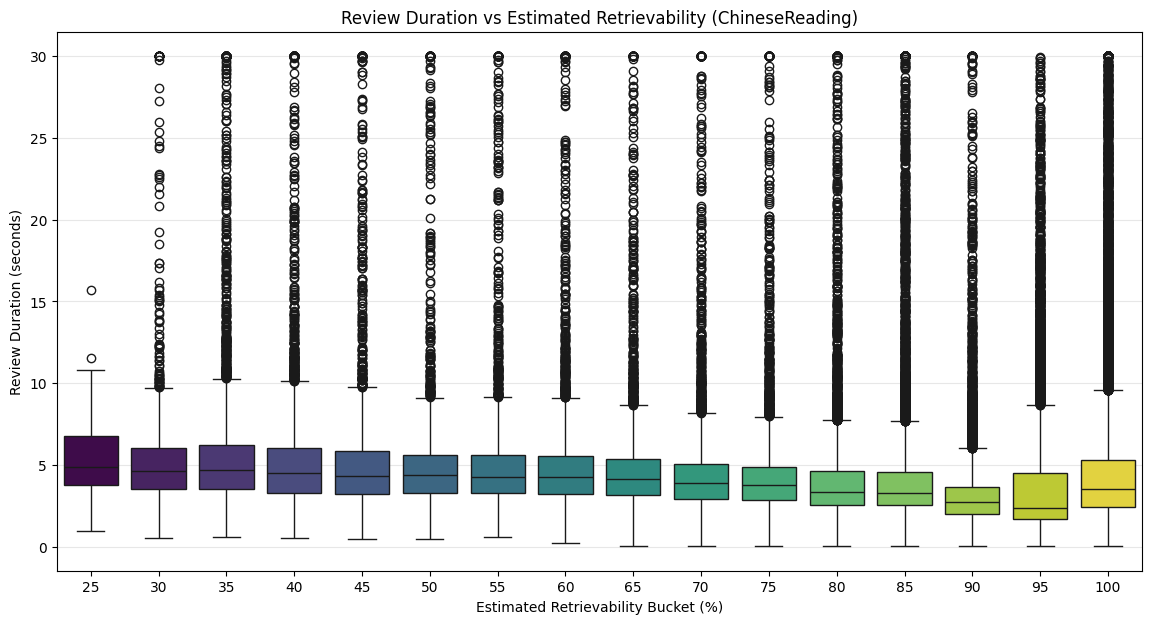

In [4]:
df_clean["retention_bucket"] = (df_clean["retention"] * 20).astype(int) * 5

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_clean,
    x="retention_bucket",
    y="duration_sec",
    palette="viridis",
    hue="retention_bucket",
    legend=False,
)
plt.title("Review Duration vs Estimated Retrievability (ChineseReading)")
plt.xlabel("Estimated Retrievability Bucket (%)")
plt.ylabel("Review Duration (seconds)")
plt.grid(axis="y", alpha=0.3)
plt.show()

## 4. Visualization: Rating vs Review Time
Comparing durations for Again, Hard, Good, and Easy ratings.

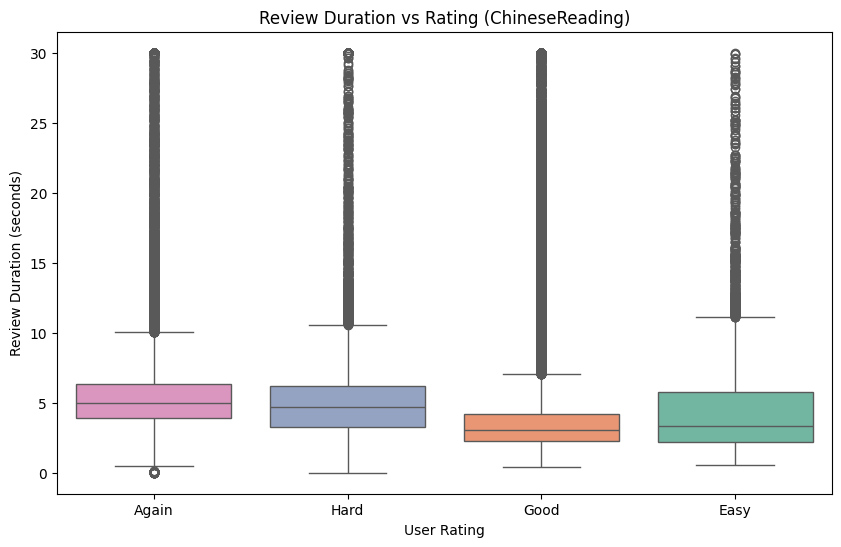

In [5]:
rating_map = {1: "Again", 2: "Hard", 3: "Good", 4: "Easy"}
df_clean["rating_label"] = df_clean["rating"].map(rating_map)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_clean,
    x="rating_label",
    y="duration_sec",
    order=["Again", "Hard", "Good", "Easy"],
    palette="Set2",
    hue="rating_label",
    legend=False,
)
plt.title("Review Duration vs Rating (ChineseReading)")
plt.xlabel("User Rating")
plt.ylabel("Review Duration (seconds)")
plt.show()

## 5. Numerical Assessment: Correlation Matrix
Checking the linear relationship strength between variables.

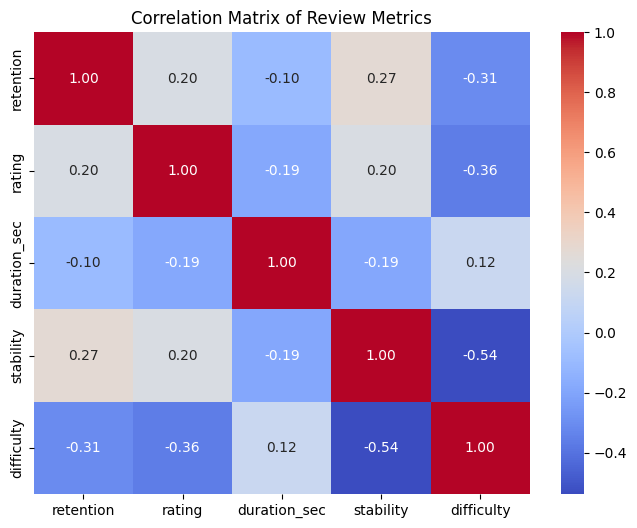

In [6]:
corr = df_clean[
    ["retention", "rating", "duration_sec", "stability", "difficulty"]
].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Review Metrics")
plt.show()

## 6. Predictive Modeling: Lasso Regression
We fit a Lasso model using cross-validation to predict duration_sec from retention and rating.

Optimal Alpha: 0.082288
R-squared: 0.0605
--- Coefficients ---
retention: -0.0557
rating: -0.5835
stability: -0.6075
difficulty: -0.0000


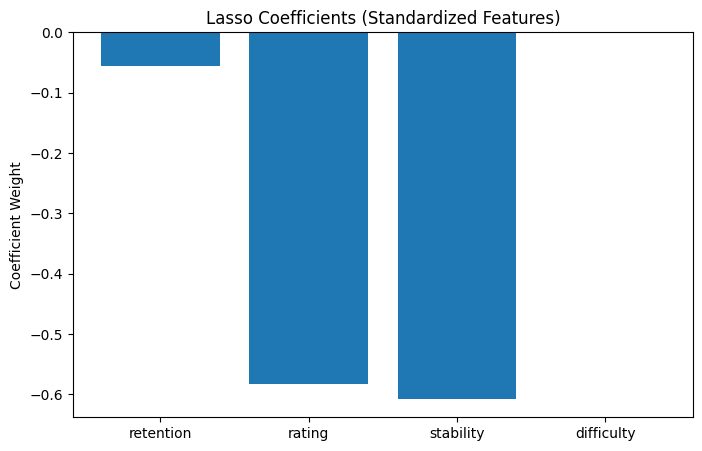

In [9]:
# Prepare features and target
features = ["retention", "rating", "stability", "difficulty"]
X = df_clean[features].values
y = df_clean["duration_sec"].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with Cross-Validation to select alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

print(f"Optimal Alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, y):.4f}")
print("--- Coefficients ---")
for feat, coef in zip(features, lasso.coef_, strict=False):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(features, lasso.coef_)
plt.title("Lasso Coefficients (Standardized Features)")
plt.ylabel("Coefficient Weight")
plt.show()